# Part 1 A different pretrained model

The question: You will use a different pertained model (other than Inception V3), and produce the entire set of results. You will submit the complete notebook, with a paragraph in the end summarizing your results.

In this part, I'll use VGG16 instead of Inception V3 model as the pretrained model and remain other settings the same.

### 1. Load data & import required packages

In [ ]:
from google.colab import drive
drive._mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir -p "/content/drive/My Drive/keras"
!mkdir -p "/content/drive/My Drive/keras/models"

In [ ]:
!pip install tensorflow==1.15.5
!pip install keras==2.1.5

     |████████████████████████████████| 110.5 MB 1.2 kB/s 
     |████████████████████████████████| 20.1 MB 57.1 MB/s 
     |████████████████████████████████| 503 kB 48.8 MB/s 
     |████████████████████████████████| 50 kB 6.2 MB/s 
     |████████████████████████████████| 3.8 MB 34.5 MB/s 
     |████████████████████████████████| 2.9 MB 44.6 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=73789dd7df87f012a0552b8b58de12a6262e7b59a04c0cc5527b2b9e7f3a3e0b
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: ten

     |████████████████████████████████| 334 kB 12.9 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 

import tensorflow as tf
from keras import backend as K
from keras.applications.inception_v3 import preprocess_input
import numpy as np

from keras.applications.vgg16 import VGG16 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report

Using TensorFlow backend.


In [ ]:
%cd drive/My Drive/keras
retina_df = pd.read_csv('trainLabels.csv')

/content/drive/My Drive/keras


In [ ]:
%cd train

retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x:'{}.jpeg'.format(x))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')

/content/drive/.shortcut-targets-by-id/1fq90qAXI4roRaWKdELFSu7nZLVKnT6Z5/train
19387 images found of 35126 total


In [ ]:
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)
from keras.utils.np_utils import to_categorical
retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
retina_df.sample(3)

,image,level,PatientId,path,exists,eye,level_cat
12171,15278_right,2,15278,15278_right.jpeg,True,0,"[0.0, 0.0, 1.0, 0.0, 0.0]"
11044,13875_left,0,13875,13875_left.jpeg,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
21892,27603_left,0,27603,27603_left.jpeg,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"


### 2. About the data
Examine the distribution of eye and severity, split data into training and validation, and balance the distribution in the training set.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1318006250>,
      dtype=object)

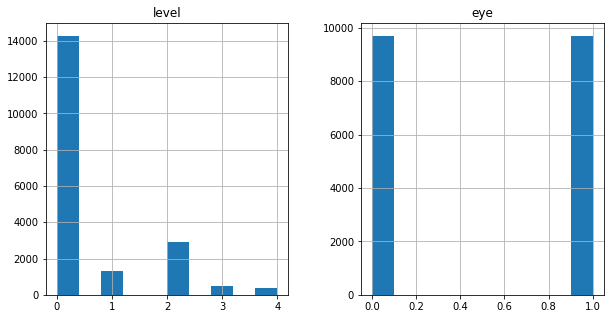

In [ ]:
retina_df[['level', 'eye']].hist(figsize = (10, 5))


In [ ]:
from sklearn.model_selection import train_test_split
rr_df = retina_df[['PatientId', 'level']].drop_duplicates()
train_ids, valid_ids = train_test_split(rr_df['PatientId'], 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = rr_df['level'])
raw_train_df = retina_df[retina_df['PatientId'].isin(train_ids)]
valid_df = retina_df[retina_df['PatientId'].isin(valid_ids)]
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 14950 validation 5273


New Data Size: 750 Old Size: 14950


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f130eaee590>,
      dtype=object)

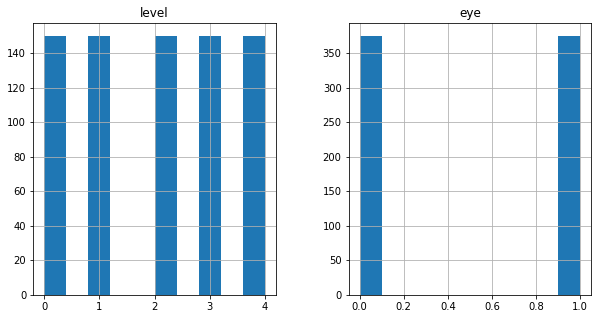

In [ ]:
train_df = raw_train_df.groupby(['level', 'eye']).apply(lambda x: x.sample(75, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['level', 'eye']].hist(figsize = (10, 5))

In [ ]:
import tensorflow as tf
from keras import backend as K

from keras.applications.inception_v3 import preprocess_input
import numpy as np
IMG_SIZE = (512, 512) # slightly smaller than vgg16 normally expects
def tf_image_loader(out_size, 
                      horizontal_flip = True, 
                      vertical_flip = False, 
                     random_brightness = True,
                     random_contrast = True,
                    random_saturation = True,
                    random_hue = True,
                      color_mode = 'rgb',
                       preproc_func = preprocess_input,
                       on_batch = False):
    def _func(X):
        with tf.name_scope('image_augmentation'):
            with tf.name_scope('input'):
                X = tf.image.decode_png(tf.read_file(X), channels = 3 if color_mode == 'rgb' else 0)
                X = tf.image.resize_images(X, out_size)
            with tf.name_scope('augmentation'):
                if horizontal_flip:
                    X = tf.image.random_flip_left_right(X)
                if vertical_flip:
                    X = tf.image.random_flip_up_down(X)
                if random_brightness:
                    X = tf.image.random_brightness(X, max_delta = 0.1)
                if random_saturation:
                    X = tf.image.random_saturation(X, lower = 0.75, upper = 1.5)
                if random_hue:
                    X = tf.image.random_hue(X, max_delta = 0.15)
                if random_contrast:
                    X = tf.image.random_contrast(X, lower = 0.75, upper = 1.5)
                return preproc_func(X)
    if on_batch: 
        # we are meant to use it on a batch
        def _batch_func(X, y):
            return tf.map_fn(_func, X), y
        return _batch_func
    else:
        # we apply it to everything
        def _all_func(X, y):
            return _func(X), y         
        return _all_func
    
def tf_augmentor(out_size,
                intermediate_size = (640, 640),
                 intermediate_trans = 'crop',
                 batch_size = 16,
                   horizontal_flip = True, 
                  vertical_flip = False, 
                 random_brightness = True,
                 random_contrast = True,
                 random_saturation = True,
                    random_hue = True,
                  color_mode = 'rgb',
                   preproc_func = preprocess_input,
                   min_crop_percent = 0.001,
                   max_crop_percent = 0.005,
                   crop_probability = 0.5,
                   rotation_range = 10):
    
    load_ops = tf_image_loader(out_size = intermediate_size, 
                               horizontal_flip=horizontal_flip, 
                               vertical_flip=vertical_flip, 
                               random_brightness = random_brightness,
                               random_contrast = random_contrast,
                               random_saturation = random_saturation,
                               random_hue = random_hue,
                               color_mode = color_mode,
                               preproc_func = preproc_func,
                               on_batch=False)
    def batch_ops(X, y):
        batch_size = tf.shape(X)[0]
        with tf.name_scope('transformation'):
            # code borrowed from https://becominghuman.ai/data-augmentation-on-gpu-in-tensorflow-13d14ecf2b19
            # The list of affine transformations that our image will go under.
            # Every element is Nx8 tensor, where N is a batch size.
            transforms = []
            identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype=tf.float32)
            if rotation_range > 0:
                angle_rad = rotation_range / 180 * np.pi
                angles = tf.random_uniform([batch_size], -angle_rad, angle_rad)
                transforms += [tf.contrib.image.angles_to_projective_transforms(angles, intermediate_size[0], intermediate_size[1])]

            if crop_probability > 0:
                crop_pct = tf.random_uniform([batch_size], min_crop_percent, max_crop_percent)
                left = tf.random_uniform([batch_size], 0, intermediate_size[0] * (1.0 - crop_pct))
                top = tf.random_uniform([batch_size], 0, intermediate_size[1] * (1.0 - crop_pct))
                crop_transform = tf.stack([
                      crop_pct,
                      tf.zeros([batch_size]), top,
                      tf.zeros([batch_size]), crop_pct, left,
                      tf.zeros([batch_size]),
                      tf.zeros([batch_size])
                  ], 1)
                coin = tf.less(tf.random_uniform([batch_size], 0, 1.0), crop_probability)
                transforms += [tf.where(coin, crop_transform, tf.tile(tf.expand_dims(identity, 0), [batch_size, 1]))]
            if len(transforms)>0:
                X = tf.contrib.image.transform(X,
                      tf.contrib.image.compose_transforms(*transforms),
                      interpolation='BILINEAR') # or 'NEAREST'
            if intermediate_trans=='scale':
                X = tf.image.resize_images(X, out_size)
            elif intermediate_trans=='crop':
                X = tf.image.resize_image_with_crop_or_pad(X, out_size[0], out_size[1])
            else:
                raise ValueError('Invalid Operation {}'.format(intermediate_trans))
            return X, y
    def _create_pipeline(in_ds):
        batch_ds = in_ds.map(load_ops, num_parallel_calls=4).batch(batch_size)
        return batch_ds.map(batch_ops)
    return _create_pipeline

In [ ]:
def flow_from_dataframe(idg, 
                        in_df, 
                        path_col,
                        y_col, 
                        shuffle = True, 
                        color_mode = 'rgb'):
    files_ds = tf.data.Dataset.from_tensor_slices((in_df[path_col].values, 
                                                   np.stack(in_df[y_col].values,0)))
    in_len = in_df[path_col].values.shape[0]
    while True:
        if shuffle:
            files_ds = files_ds.shuffle(in_len) # shuffle the whole dataset
        
        next_batch = idg(files_ds).repeat().make_one_shot_iterator().get_next()
        for i in range(max(in_len//32,1)):
            # NOTE: if we loop here it is 'thread-safe-ish' if we loop on the outside it is completely unsafe
            yield K.get_session().run(next_batch)

In [ ]:
batch_size = 10
core_idg = tf_augmentor(out_size = IMG_SIZE, 
                        color_mode = 'rgb', 
                        vertical_flip = True,
                        crop_probability=0.0, # crop doesn't work yet
                        batch_size = batch_size) 
valid_idg = tf_augmentor(out_size = IMG_SIZE, color_mode = 'rgb', 
                         crop_probability=0.0, 
                         horizontal_flip = False, 
                         vertical_flip = False, 
                         random_brightness = False,
                         random_contrast = False,
                         random_saturation = False,
                         random_hue = False,
                         rotation_range = 0,
                        batch_size = batch_size)

train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'level_cat')

valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat') # we can use much larger batches for evaluation

### 3. Validation Set and training set




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.






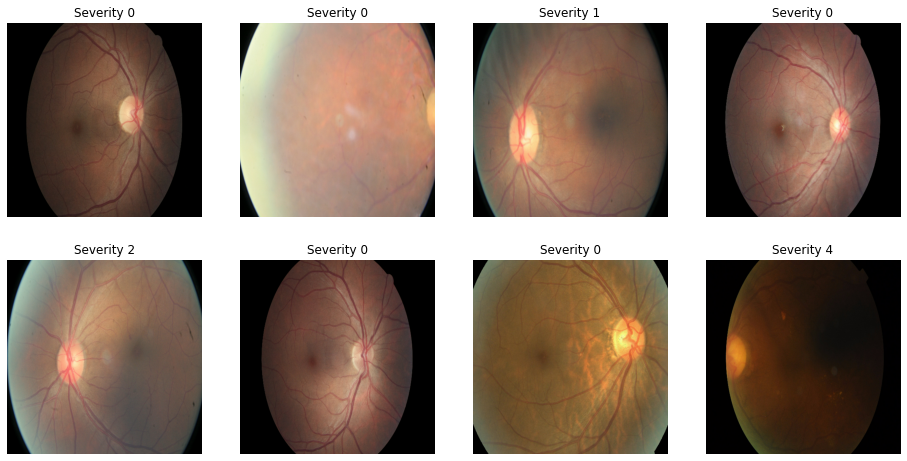

In [ ]:
t_x, t_y = next(valid_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

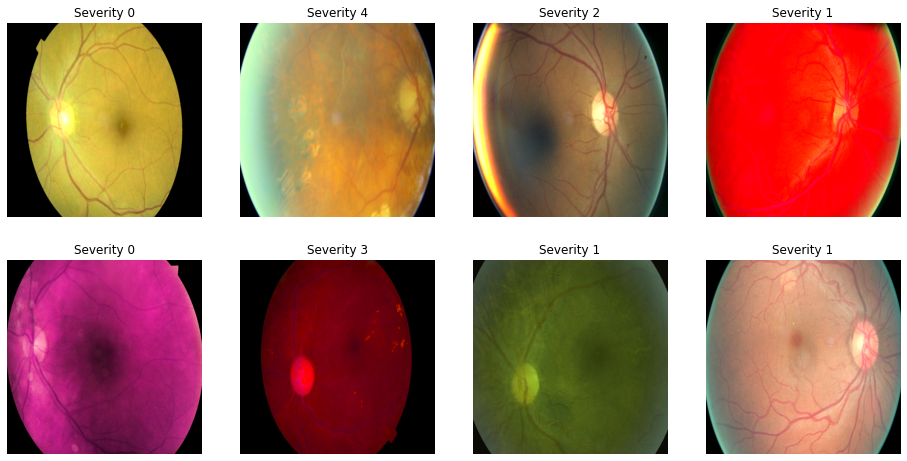

In [ ]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

### 4. The attention model

In [ ]:
in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
retina_model.summary()




58892288/58889256 [==============================] - 1s 0us/step




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 16, 16, 512)  14714688    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 512)  2048        vgg16[1][0]                      
__________________________________________________________________________________________________
dropout_1 (Dropout)

In [ ]:
weight_path="{}_weights.best.hdf5".format('retina')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
!rm -rf ~/.keras

In [ ]:
retina_model.fit_generator(train_gen, 
                           steps_per_epoch = train_df.shape[0]//batch_size,
                           validation_data = valid_gen, 
                           validation_steps = valid_df.shape[0]//batch_size,
                           epochs = 1, 
                           callbacks = callbacks_list,
                           workers = 0, # tf-generators are not thread-safe
                           use_multiprocessing=False, 
                           max_queue_size = 0
                           )

Epoch 1/1
37/37 [==============================] - 6563s 177s/step - loss: 1.5560 - categorical_accuracy: 0.2892 - top_2_accuracy: 0.4973 - val_loss: 1.5005 - val_categorical_accuracy: 0.1781 - val_top_2_accuracy: 0.6053

Epoch 00001: val_loss improved from inf to 1.50052, saving model to retina_weights.best.hdf5


In [ ]:
retina_model.load_weights('/content/drive/My Drive/retina_weights.best.hdf5')
retina_model.save('full_retina_model.h5')

In [ ]:
##### create one fixed dataset for evaluating
from tqdm import tqdm_notebook
# fresh valid gen
valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat') 
vbatch_count = (valid_df.shape[0]//batch_size-1)
out_size = vbatch_count*batch_size
test_X = np.zeros((out_size,)+t_x.shape[1:], dtype = np.float32)
test_Y = np.zeros((out_size,)+t_y.shape[1:], dtype = np.float32)
for i, (c_x, c_y) in zip(tqdm_notebook(range(vbatch_count)), 
                         valid_gen):
    j = i*batch_size
    test_X[j:(j+c_x.shape[0])] = c_x
    test_Y[j:(j+c_x.shape[0])] = c_y

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat') 
vbatch_count = (valid_df.shape[0]//batch_size-1)
out_size = vbatch_count*batch_size
test_X = np.zeros((out_size,)+t_x.shape[1:], dtype = np.float32)
test_Y = np.zeros((out_size,)+t_y.shape[1:], dtype = np.float32)

### 5. Show attention and evaluate the results


In [ ]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in retina_model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

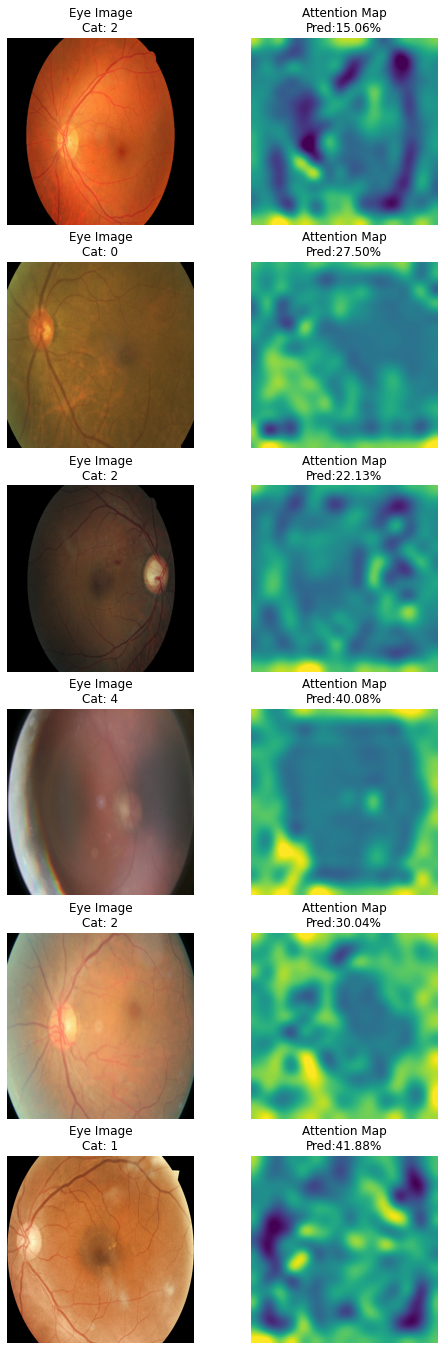

In [ ]:
import keras.backend as K
rand_idx = np.random.choice(range(len(test_X)), size = 6)
attn_func = K.function(inputs = [retina_model.get_input_at(0), K.learning_phase()],
           outputs = [attn_layer.get_output_at(0)]
          )
fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx+1)]
    attn_img = attn_func([cur_img, 0])[0]
    img_ax.imshow(np.clip(cur_img[0,:,:,:]*127+127, 0, 255).astype(np.uint8))
    attn_ax.imshow(attn_img[0, :, :, 0]/attn_img[0, :, :, 0].max(), cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
    real_cat = np.argmax(test_Y[c_idx, :])
    img_ax.set_title('Eye Image\nCat:%2d' % (real_cat))
    pred_cat = retina_model.predict(cur_img)
    attn_ax.set_title('Attention Map\nPred:%2.2f%%' % (100*pred_cat[0,real_cat]))
fig.savefig('attention_map.png', dpi = 300)

In [ ]:
pred_Y = retina_model.predict(test_X, batch_size = 16, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(test_Y, -1)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat)))
print(classification_report(test_Y_cat, pred_Y_cat))

2260/2260 [==============================] - 4706s 2s/step
Accuracy on Test Data: 0.00%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    2260.0
           2       0.00      0.00      0.00       0.0

    accuracy                           0.00    2260.0
   macro avg       0.00      0.00      0.00    2260.0
weighted avg       0.00      0.00      0.00    2260.0



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


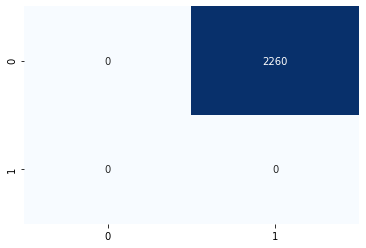

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_Y_cat, pred_Y_cat), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, vmax = test_X.shape[0]//16)

### 6. Summary

First, I tried to use the original batch size 64 and original setting of number of epochs which is 25, but it took hours to train and caused out of memory error. Than I used batch size = 10 and epoch = 1.

Second, when I used only one epoch, it still took nearly three hours to train when coming to the end (from 36/37 to 37/37). 

So at last I only got the loss = 1.5560 with categorical_accuracy 0.2892 and top_2_accuracy 0.4973. The val_loss is 1.5005 with val_categorical_accuracy 0.1781 and val_top_2_accuracy 0.6053.
